#Source adapted from:
[News classification using HuggingFace DistilBert
](https://www.kaggle.com/code/atechnohazard/news-classification-using-huggingface-distilbert/input)

In [ ]:
import kagglehub
amananandrai_ag_news_classification_dataset_path = kagglehub.dataset_download('amananandrai/ag-news-classification-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'ag-news-classification-dataset' dataset.
Data source import complete.


# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import DistilBertTokenizer, DistilBertConfig, TFDistilBertModel

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Conv2D, Conv1D, MaxPooling1D, Dense, Dropout, GlobalMaxPooling1D, Input, Bidirectional, concatenate, Flatten, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

# enable GPU memory growth if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, enable=True)
        print('GPUs found and memory growth enabled.')
    except RuntimeError as e:
        print(e)

# strategy for GPU or CPU
if physical_devices:
    strategy = tf.distribute.MirroredStrategy()
    print('Using MirroredStrategy for GPU(s).')
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
    print('No GPU devices found, using OneDeviceStrategy for CPU.')

No GPU devices found, using OneDeviceStrategy for CPU.


# Load data



In [ ]:
TRAIN_FILE_PATH = '/kaggle/input/ag-news-classification-dataset/train.csv'
TEST_FILE_PATH = '/kaggle/input/ag-news-classification-dataset/test.csv'

data = pd.read_csv(TRAIN_FILE_PATH)
testdata = pd.read_csv(TEST_FILE_PATH)

# training data
data = data.sample(n=1000)
# test data
testdata = testdata.sample(n=1000)

X_train = data['Title'] + " " + data['Description']
y_train = data['Class Index'].apply(lambda x: x-1).values # Classes need to begin from 0

x_test = testdata['Title'] + " " + testdata['Description']
y_test = testdata['Class Index'].apply(lambda x: x-1).values # Classes need to begin from 0

maxlen = X_train.map(lambda x: len(x.split())).max()
data.describe()

,Class Index
count,1000.000000
mean,2.487000
std,1.118518
min,1.000000
25%,1.000000
50%,3.000000
75%,3.000000
max,4.000000


#Baseline

In [ ]:
keywords = {
    0: ["government", "country", "law", "poverty", "war"],
    1: ["competition","match", "player", "wins", "loses"],
    2: ["business", "company", "stock", "market", "profit"],
    3: ["science", "vaccine", "technology", "computer", "ai"]
}

def baseline_predict(headline):
  headline = str(headline).lower()

  scores = {label: 0 for label in keywords}

  for label, words in keywords.items():
    for word in words:
      if word in headline:
        scores[label] += 1

  best_label = max(scores, key=scores.get)

  # If no keyword matches, the first category (world) would act as the default category.

  if scores[best_label] == 0:
    return 0

  return best_label

from sklearn.metrics import accuracy_score, recall_score, precision_score

y_pred_baseline = [baseline_predict(headline) for headline in x_test]

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_recall = recall_score(y_test, y_pred_baseline, average="macro")
baseline_precision = precision_score(y_test, y_pred_baseline, average="macro")

print(f"Baseline accuracy: {baseline_accuracy:.2f}")
print(f"Baseline recall: {baseline_recall:.2f}")
print(f"Baseline precision: {baseline_precision:.2f}")

Baseline accuracy: 0.33
Baseline recall: 0.33
Baseline precision: 0.47


# Define tokenizer

In [ ]:
vocab_size = 20000
embed_size = 32
distil_bert = 'distilbert-base-uncased'

tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, padding='max_length', truncation=True, max_length=maxlen)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, padding='max_length', truncation=True,
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

# Tokenize data using defined tokenizer

In [ ]:
# Tokenize desc and title train data
X_train = tokenize(X_train, tokenizer)
x_test = tokenize(x_test, tokenizer)

100%|██████████| 1000/1000 [00:00<00:00, 1530.73it/s]


# Define model in TPU scope

In [ ]:
class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self, transformer_model, **kwargs):
        super(TransformerLayer, self).__init__(**kwargs)
        self.transformer = transformer_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        # The transformer model returns a BaseModelOutput object
        # The first element [0] or .last_hidden_state contains the sequence output
        transformer_output = self.transformer(input_ids, attention_mask=attention_mask)
        return transformer_output[0]

with strategy.scope():
    config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
    config.output_hidden_states = False
    transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config=config, from_pt=True)

    # Instantiate the custom layer wrapper
    transformer_wrapper = TransformerLayer(transformer_model)

    input_ids_in = tf.keras.layers.Input(shape=(maxlen,), name='input_token', dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(maxlen,), name='masked_token', dtype='int32')

    # Pass the KerasTensors to the custom wrapper layer
    embedding_layer = transformer_wrapper([input_ids_in, input_masks_in])

    X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedding_layer)
    X = tf.keras.layers.GlobalMaxPool1D()(X)
    X = tf.keras.layers.Dense(64, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    X = tf.keras.layers.Dense(4, activation='sigmoid')(X)
    model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

    for layer in model.layers[:3]:
        layer.trainable = False

    model.summary()
    # Move model.compile inside the strategy.scope()
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the mode

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_token         │ (None, 106)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_token        │ (None, 106)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer   │ (None, 106, 768)  │          0 │ input_token[0][0… │
│ (TransformerLayer)  │                   │            │ masked_token[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 106, 128)  │    426,496 │ transformer_laye… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ bidirectional[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 435,012 (1.66 MB)

 Trainable params: 435,012 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

# Compile and fit model

In [ ]:
callbacks = [
#     EarlyStopping(
#         monitor='val_accuracy',
#         min_delta=1e-4,
#         patience=4,
#         verbose=1
#     ),
    ModelCheckpoint(
        filepath='weights.weights.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [ ]:
model.fit([X_train[0], X_train[1]], y_train, batch_size=32, validation_data=([x_test[0], x_test[1]], y_test), epochs=4, callbacks=callbacks)

Epoch 1/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9898 - loss: 0.0337
Epoch 1: val_accuracy did not improve from 0.88800
32/32 ━━━━━━━━━━━━━━━━━━━━ 293s 9s/step - accuracy: 0.9898 - loss: 0.0338 - val_accuracy: 0.8880 - val_loss: 0.3878
Epoch 2/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9963 - loss: 0.0223
Epoch 2: val_accuracy did not improve from 0.88800
32/32 ━━━━━━━━━━━━━━━━━━━━ 301s 10s/step - accuracy: 0.9963 - loss: 0.0223 - val_accuracy: 0.8840 - val_loss: 0.4259
Epoch 3/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9969 - loss: 0.0140
Epoch 3: val_accuracy improved from 0.88800 to 0.89300, saving model to weights.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 354s 11s/step - accuracy: 0.9969 - loss: 0.0140 - val_accuracy: 0.8930 - val_loss: 0.4894
Epoch 4/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9957 - loss: 0.0231
Epoch 4: val_accuracy did not improve from 0.89300
32/32 ━━━━━━━━━━━━━━━━━━━━ 295s 9s/step - accuracy: 0.9956 - loss: 0.0235 - va

In [ ]:
model.load_weights('weights.weights.h5')

# Test model with some arbitrary data

In [ ]:
labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']

test = ['New evidence of virus risks from wildlife trade', 'Coronavirus: Bank pumps £100bn into UK economy to aid recovery',
        'Trump\'s bid to end Obama-era immigration policy ruled unlawful', 'David Luiz’s future with Arsenal to be decided this week']
test_seq = tokenize(test, tokenizer)
test_preds = [labels[np.argmax(i)] for i in model.predict([test_seq[0], test_seq[1]])]

for news, label in zip(test, test_preds):
    print('{} - {}'.format(news, label))

100%|██████████| 4/4 [00:00<00:00, 1256.91it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
New evidence of virus risks from wildlife trade - Science-Technology News
Coronavirus: Bank pumps £100bn into UK economy to aid recovery - Business News
Trump's bid to end Obama-era immigration policy ruled unlawful - World News
David Luiz’s future with Arsenal to be decided this week - Sports News


# Plot confusion matrix

32/32 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step


<Figure size 640x480 with 0 Axes>

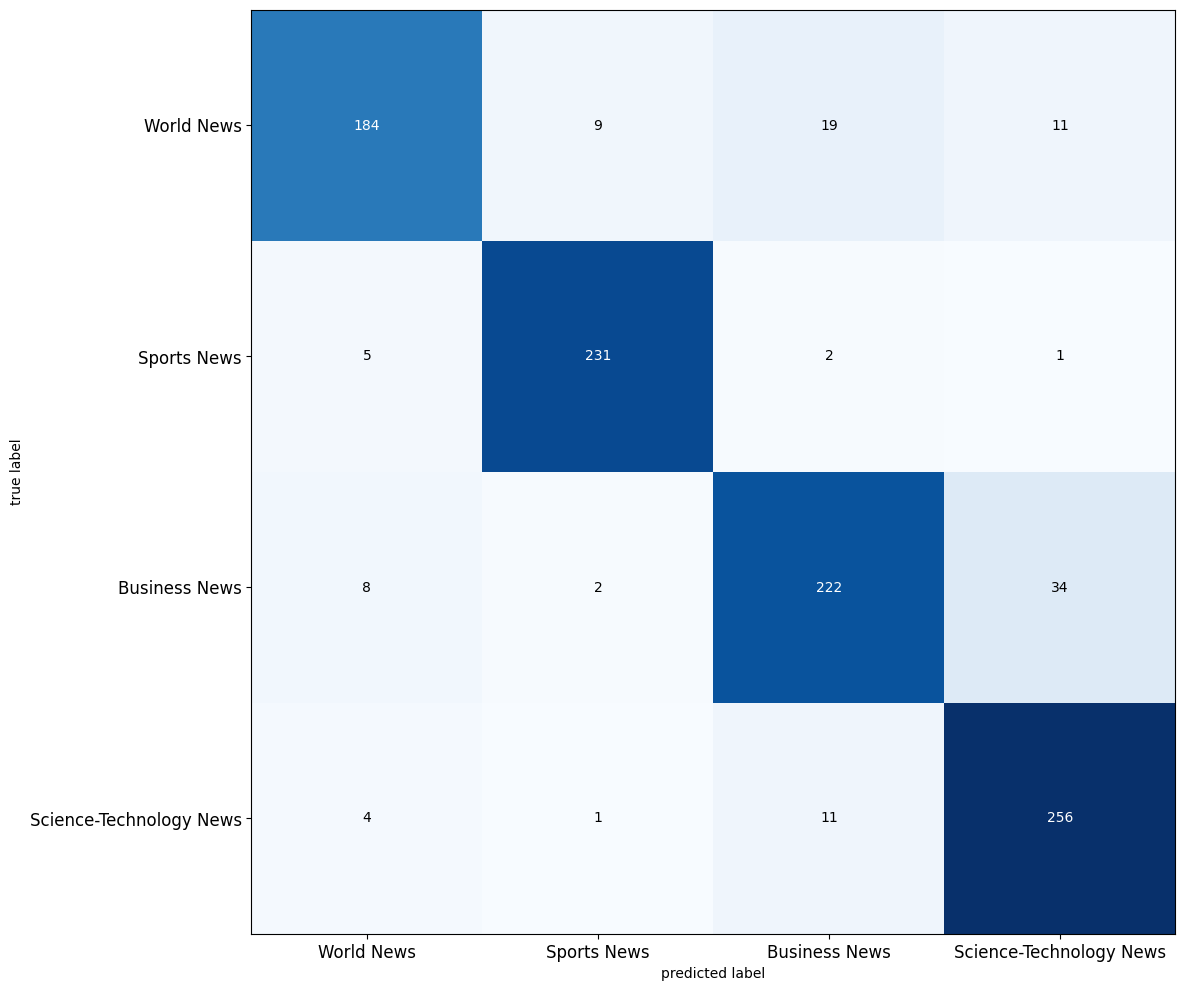

In [ ]:
preds = [np.argmax(i) for i in model.predict([x_test[0], x_test[1]])]
cm  = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize=12)
plt.yticks(range(4), labels, fontsize=12)
plt.show()

# Get precision and recall scores

In [ ]:
print("Recall of the model is {:.2f}".format(recall_score(y_test, preds, average='micro')))
print("Precision of the model is {:.2f}".format(precision_score(y_test, preds, average='micro')))

Recall of the model is 0.89
Precision of the model is 0.89
